In [1]:
#Работа имеет странную структуру, зато в ней прослеживается ход исследования.

## Методы машинного обучения в мониторинге акваторий с помощью ДЗЗ

Датасет - данные SentinelHub, собран и размечен вручную.

Постановка задачи: на вход подаются спутниковые снимки в видимом диапазоне. Модель должна определять участки загрязнения для выбранной области интереса. Выделим три класса: отсутствие загрязнения (0), загрязнение (1), корабль 
(2).

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np 
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import pandas as pd
import os
from VisExtract import VisExtract
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

%matplotlib inline

Импорт зависимостей. В классе VisExtract реализованно построение изображений в пространстве RGB.

Выведем данные, как они есть:

In [5]:
def read_image(directory, img_name):
    return cv2.cvtColor(cv2.imread(f'{directory}/{img_name}'), cv2.COLOR_RGB2BGR)

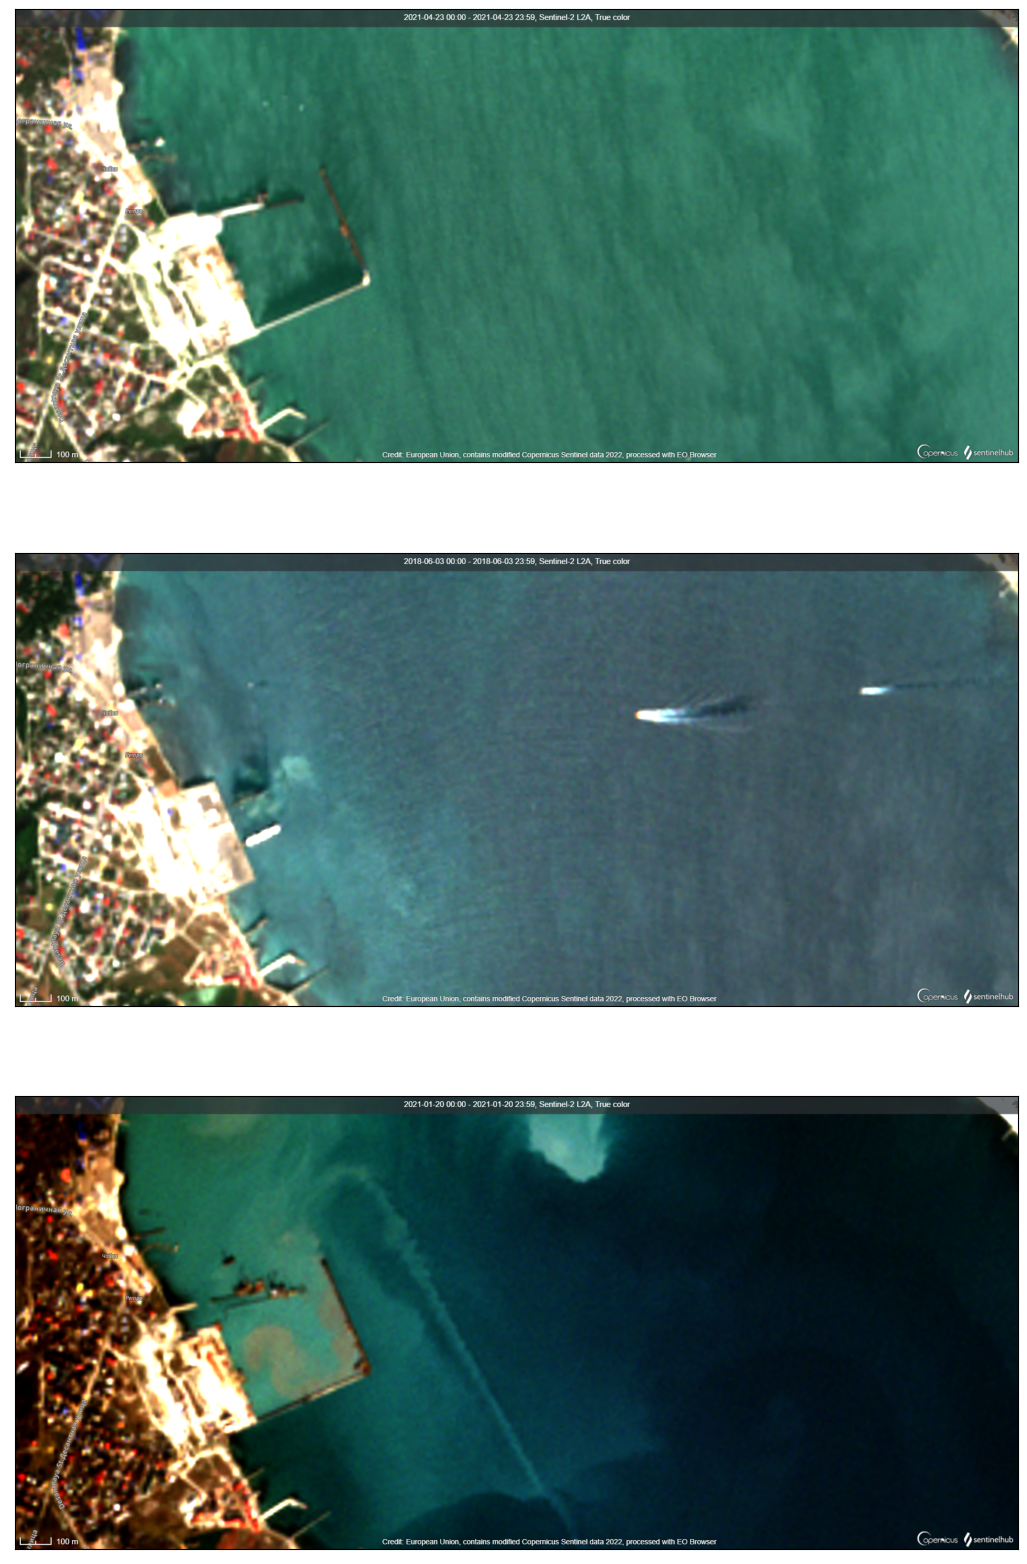

In [6]:
np.random.seed(23)
directory = 'unsplited'
filelist = np.random.choice(os.listdir(directory), size=4)
f, axarr = plt.subplots(3, 1, figsize=(20, 20))

for i in range(1, 4):
    axarr[i - 1].imshow(read_image(directory, filelist[i]))
    axarr[i - 1].set_xticks([]), axarr[i - 1].set_yticks([])

Разобьем область интереса на мелкие части, так как внутри области для классификации могут быть области, относимые ко всем трём классам:

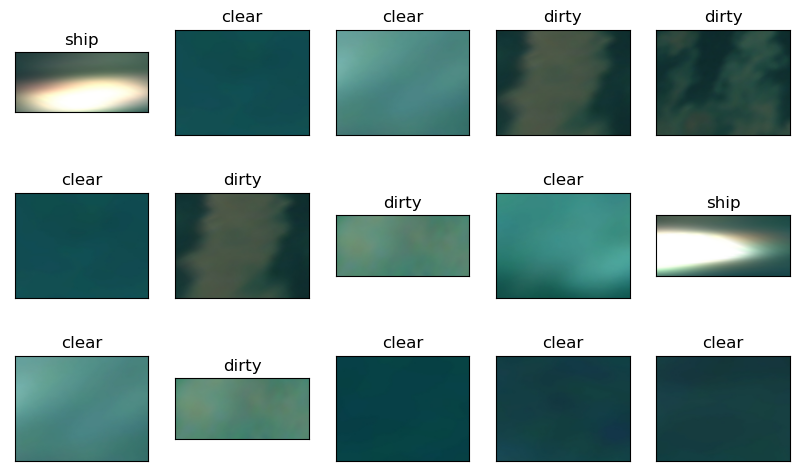

In [7]:
n_rows = 3
n_cols = 5

np.random.seed(34)
filelist = np.random.choice(os.listdir('data'), size=n_cols * n_cols)

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 6))


name = {'0': 'clear', '1': 'dirty', '2': 'ship'}


for i in range(1, n_rows + 1):
    for j in range(1, n_cols + 1):
        axarr[i - 1, j - 1].imshow(read_image('data', filelist[i * j]))
        axarr[i - 1, j - 1].set_xticks([]), axarr[i - 1, j - 1].set_yticks([])
        axarr[i - 1, j - 1].set_title(name[filelist[i * j][0]])

Начнём с самого наивного подхода, будем высчитывать средние по изображениям.
Представим данные в пространстве, координаты - средние значения RGB каналов.

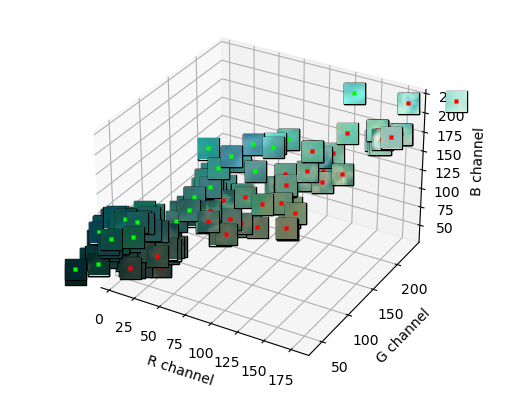

In [4]:
''' 
file_name (str): file name (relative path) of file with data
num (int): number of images to display
action(str, optional): what to do: show 3d-graph or save it in WD: save or show
ships(bool, optional): display or not ships images
aver(str, optional): statistical estimator to be used: mode, median or mean
'''

vis = VisExtract('data', len(os.listdir('data')), 'show')

Видно, что при таком количестве классов данные неплохо разделимы и линейно. Также отметим сильную корреляцию между признаками.

In [5]:
np.corrcoef(vis.data, rowvar=False)

array([[1.        , 0.89792468, 0.81459606],
       [0.89792468, 1.        , 0.96530377],
       [0.81459606, 0.96530377, 1.        ]])

Применим метод главных компонент из методических соображений, так как данные и так отлично разделимы:

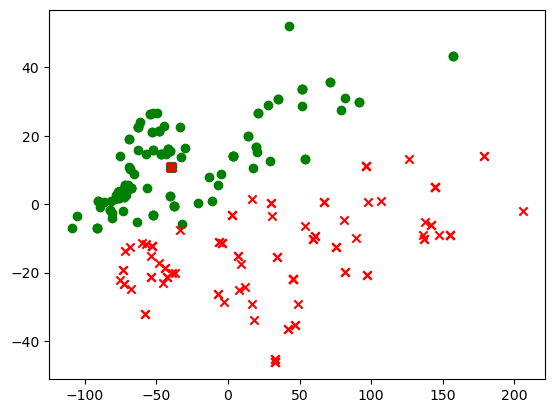

In [6]:
pca_3d = PCA(n_components=2, svd_solver='full')
two_dim = pca_3d.fit_transform(vis.data)

clr = np.where(vis.y == 0)
dr = np.where(vis.y == 1)

plt.scatter(two_dim[clr, 0], two_dim[clr, 1], c = 'g')
plt.scatter(two_dim[dr, 0], two_dim[dr, 1], c = 'r', marker='x')

Заметим странность, объект из класса загрязнение попал к чистым, да еще и "залез" прямо на другой объект!

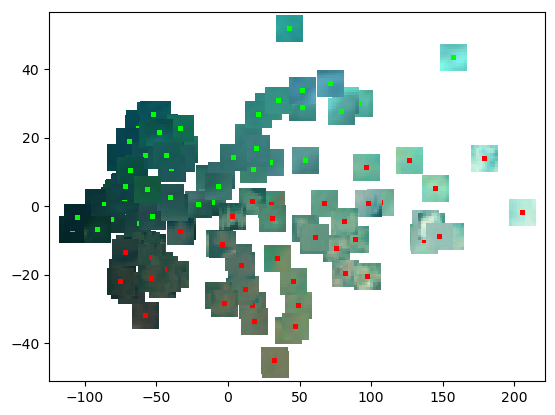

In [7]:
vis.two_dim_im_graph(two_dim, vis.imgs)

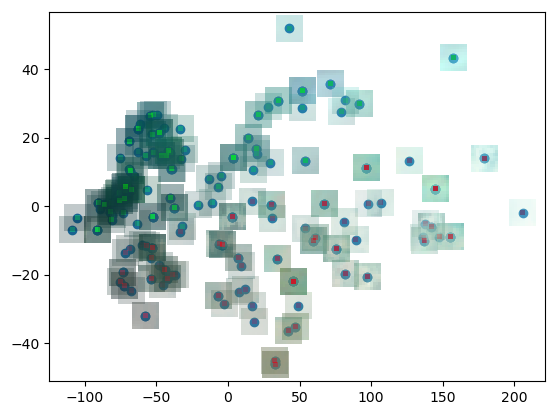

In [8]:
vis.two_dim_im_graph(two_dim, vis.imgs, alpha=0.25)

На изображении выше все нормально, этого выброса нет.

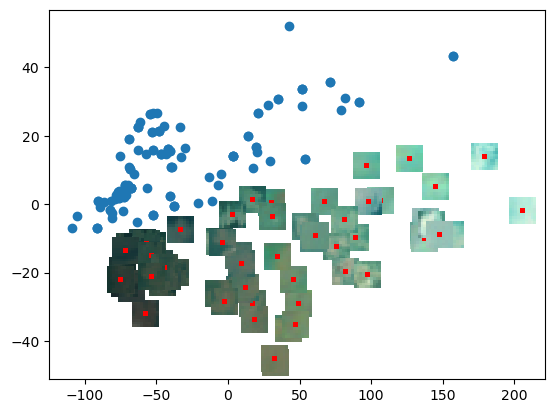

In [9]:
vis.two_dim_im_graph(two_dim, vis.imgs, flag='drt')

Причину этого мне так и не удалось выяснить.

Так как с вычислительными мощностями проблем не имеем, вернёмся к трехмерному случаю:

In [10]:
(trainData, testData, trainLabels, testLabels) = train_test_split(vis.data, vis.y, test_size=0.3, random_state=41)

Произведём раздельную Standart Scale нормировку:

In [11]:
sc = StandardScaler()
trainData = sc.fit_transform(trainData)
testData = sc.fit_transform(testData)

Обучим модель логистической регрессии:

In [12]:
model = LogisticRegression(random_state=0, solver = 'lbfgs').fit(trainData, trainLabels)

Построим разделяющую плоскость:

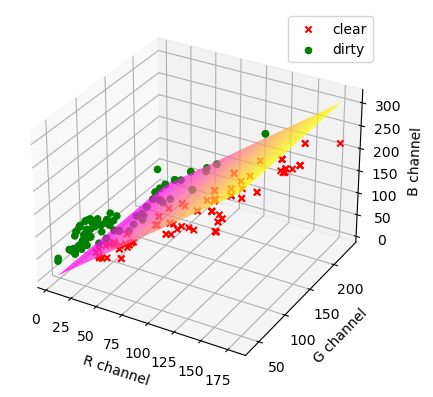

In [13]:
vis.add_hyperplane(list((model.coef_[0][0], model.coef_[0][1], model.coef_[0][2], model.intercept_[0])))

Выведем метрики качества:

In [14]:
predLabels = model.predict(testData)
from sklearn.metrics import classification_report
print(classification_report(testLabels, predLabels, digits=3))

              precision    recall  f1-score   support

           0      0.974     0.974     0.974        38
           1      0.969     0.969     0.969        32

    accuracy                          0.971        70
   macro avg      0.971     0.971     0.971        70
weighted avg      0.971     0.971     0.971        70



Действительно, данные отлично разделимы линейно. Однако, это решение задачи классификации clear vs. dirty, но ведь на изображении могут быть и корабли. Смотрим:

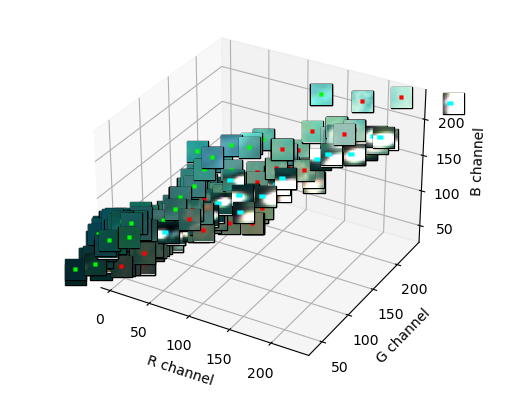

In [15]:
vis = VisExtract('data', len(os.listdir('data')), 'show', ships=True)

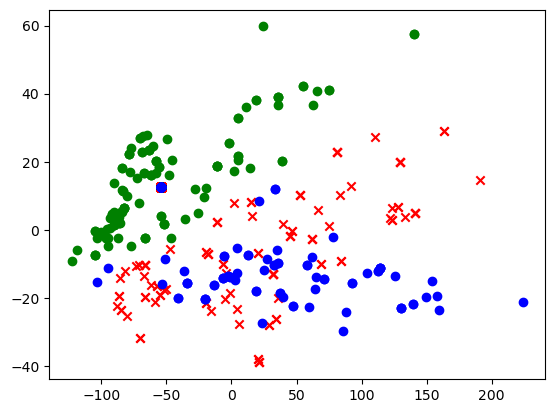

In [16]:
pca_3d = PCA(n_components=2, svd_solver='full')
two_dim = pca_3d.fit_transform(vis.data)

clr = np.where(vis.y == 0)
dr = np.where(vis.y == 1)
sh = np.where(vis.y == 2)

plt.scatter(two_dim[clr, 0], two_dim[clr, 1], c = 'g')
plt.scatter(two_dim[dr, 0], two_dim[dr, 1], c = 'r', marker='x')
plt.scatter(two_dim[sh, 0], two_dim[sh, 1], c = 'b', marker='o')

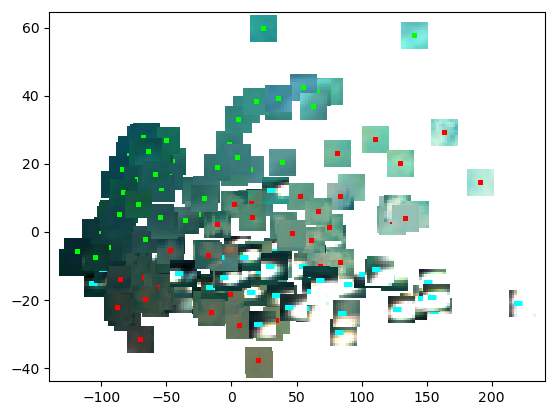

In [17]:
vis.two_dim_im_graph(two_dim, vis.imgs)

Здесь все несколько хуже. Если представить данные в RGB пространстве, используя как предиктор среднее значение по каналу RGB, то разделить их на три класса не выйдет. Попробуем использовать как предикторы гисторгаммы изображений.

In [8]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [9]:
imagePaths = sorted(list(os.listdir('data')))
data = []
labels = []

for file in imagePaths:
    image = cv2.imread(f'data/{file}', 1)
    label = file[0]
    hist = extract_histogram(image)
    data.append(hist)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

Но сначала применим метод главных компонент.

In [10]:
comps = 45

pca = PCA(n_components=comps, svd_solver='full')

In [11]:
(trainData, testData, trainLabels, testLabels) = train_test_split(data, labels, test_size=0.3, random_state=41)
(trainData_pca, testData_pca, trainLabels, testLabels) = train_test_split(pca.fit_transform(data), labels,
                                                                                            test_size=0.3,
                                                                                            random_state=41)

Возьмём 45 ГК, так как при большем количестве прирост объяснённой дисперсии равен нулю.

array([0.164, 0.295, 0.388, 0.469, 0.517, 0.564, 0.609, 0.648, 0.685,
       0.714, 0.742, 0.768, 0.789, 0.808, 0.827, 0.842, 0.857, 0.871,
       0.884, 0.896, 0.907, 0.918, 0.927, 0.935, 0.941, 0.948, 0.954,
       0.959, 0.964, 0.969, 0.973, 0.977, 0.98 , 0.983, 0.986, 0.988,
       0.99 , 0.991, 0.993, 0.994, 0.995, 0.996, 0.996, 0.997, 0.997],
      dtype=float32)

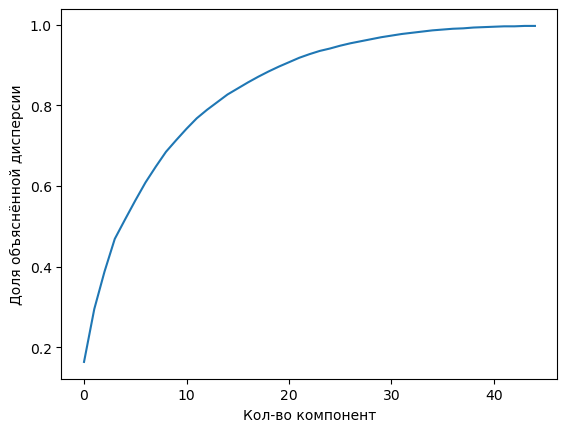

In [12]:
explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)
plt.xlabel('Кол-во компонент')
plt.ylabel('Доля объяснённой дисперсии')
plt.plot(np.arange(comps), explained_variance, ls = '-')
explained_variance

Используем метод опорных векторов с мягким зазором, используя сеточный подбор гиперпараметров.

In [13]:
params = {'kernel':('linear', 'rbf', 'sigmoid'), 'C': np.linspace(0.1, 30, 35)}
model_svc = svm.SVC(random_state=41)

В качестве метрики используем F1-score-micro.

In [14]:
finder_svc = GridSearchCV(model_svc, params, scoring='f1_micro')
finder_svc.fit(trainData, trainLabels)

GridSearchCV(estimator=SVC(random_state=41),
             param_grid={'C': array([ 0.1       ,  0.97941176,  1.85882353,  2.73823529,  3.61764706,
        4.49705882,  5.37647059,  6.25588235,  7.13529412,  8.01470588,
        8.89411765,  9.77352941, 10.65294118, 11.53235294, 12.41176471,
       13.29117647, 14.17058824, 15.05      , 15.92941176, 16.80882353,
       17.68823529, 18.56764706, 19.44705882, 20.32647059, 21.20588235,
       22.08529412, 22.96470588, 23.84411765, 24.72352941, 25.60294118,
       26.48235294, 27.36176471, 28.24117647, 29.12058824, 30.        ]),
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             scoring='f1_micro')

In [15]:
finder_svc_pca = GridSearchCV(model_svc, params, scoring='f1_micro')
finder_svc_pca.fit(trainData_pca, trainLabels)

GridSearchCV(estimator=SVC(random_state=41),
             param_grid={'C': array([ 0.1       ,  0.97941176,  1.85882353,  2.73823529,  3.61764706,
        4.49705882,  5.37647059,  6.25588235,  7.13529412,  8.01470588,
        8.89411765,  9.77352941, 10.65294118, 11.53235294, 12.41176471,
       13.29117647, 14.17058824, 15.05      , 15.92941176, 16.80882353,
       17.68823529, 18.56764706, 19.44705882, 20.32647059, 21.20588235,
       22.08529412, 22.96470588, 23.84411765, 24.72352941, 25.60294118,
       26.48235294, 27.36176471, 28.24117647, 29.12058824, 30.        ]),
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             scoring='f1_micro')

Посмотрим на результаты:

In [16]:
svc_res_df = pd.DataFrame(finder_svc.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
svc_res_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
22       0.002992  9.536743e-08         0.001995    2.132481e-07  6.255882   
19       0.003391  7.979393e-04         0.001396    4.885777e-04  5.376471   
16       0.003391  4.887723e-04         0.001795    3.989697e-04  4.497059   
13       0.002992  2.431402e-07         0.001995    2.611745e-07  3.617647   
7        0.003191  3.989697e-04         0.001995    1.907349e-07  1.858824   

   param_kernel                                      params  \
22          rbf  {'C': 6.2558823529411764, 'kernel': 'rbf'}   
19          rbf   {'C': 5.376470588235294, 'kernel': 'rbf'}   
16          rbf   {'C': 4.497058823529411, 'kernel': 'rbf'}   
13          rbf  {'C': 3.6176470588235294, 'kernel': 'rbf'}   
7           rbf  {'C': 1.8588235294117648, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  \
22           0.954545           0.931818           0.976744   
19           0.954545           0.931818           0.976744   
16           0.954545           0.954545           0.953488   
13           0.954545           0.977273           0.953488   
7            0.954545           0.977273           0.953488   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
22           0.906977           0.930233         0.940063        0.023726   
19           0.906977           0.930233         0.940063        0.023726   
16           0.906977           0.930233         0.939958        0.018926   
13           0.906977           0.906977         0.939852        0.028156   
7            0.906977           0.906977         0.939852        0.028156   

    rank_test_score  
22                1  
19                1  
16                3  
13                4  
7                 4

In [17]:
svc_pca_res_df = pd.DataFrame(finder_svc_pca.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
svc_pca_res_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
13       0.001990  8.761356e-06         0.001002    9.572914e-06  3.617647   
19       0.001799  4.012261e-04         0.000798    3.989458e-04  5.376471   
16       0.001387  4.843038e-04         0.001205    3.964403e-04  4.497059   
7        0.001795  3.988982e-04         0.000997    6.143617e-07  1.858824   
10       0.000997  3.234067e-07         0.000997    4.623108e-07  2.738235   

   param_kernel                                      params  \
13          rbf  {'C': 3.6176470588235294, 'kernel': 'rbf'}   
19          rbf   {'C': 5.376470588235294, 'kernel': 'rbf'}   
16          rbf   {'C': 4.497058823529411, 'kernel': 'rbf'}   
7           rbf  {'C': 1.8588235294117648, 'kernel': 'rbf'}   
10          rbf   {'C': 2.738235294117647, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  \
13           0.954545           0.977273           0.953488   
19           0.954545           0.931818           0.976744   
16           0.954545           0.931818           0.976744   
7            0.954545           0.977273           0.953488   
10           0.954545           0.977273           0.953488   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
13           0.906977           0.930233         0.944503        0.023947   
19           0.906977           0.930233         0.940063        0.023726   
16           0.906977           0.930233         0.940063        0.023726   
7            0.906977           0.906977         0.939852        0.028156   
10           0.906977           0.906977         0.939852        0.028156   

    rank_test_score  
13                1  
19                2  
16                2  
7                 4  
10                4

Как видим, метрики качества cовсем незначительно изменились. Но сравним время на поиск:

In [18]:
print(f'Суммарное время на обучение без МГК: {svc_res_df.mean_fit_time.sum()}')
print(f'Суммарное время на обучение c МГК: {svc_pca_res_df.mean_fit_time.sum()}')

Суммарное время на обучение без МГК: 0.26545047760009766
Суммарное время на обучение c МГК: 0.14457483291625975


Проделаем то же с логистической регрессией:

In [19]:
params = {'C': np.linspace(0.1, 30, 35)}
model_lr = LogisticRegression(random_state=41, max_iter=5000)

In [20]:
finder_lr = GridSearchCV(model_lr, params, scoring='f1_micro')
finder_lr.fit(trainData_pca, trainLabels)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, random_state=41),
             param_grid={'C': array([ 0.1       ,  0.97941176,  1.85882353,  2.73823529,  3.61764706,
        4.49705882,  5.37647059,  6.25588235,  7.13529412,  8.01470588,
        8.89411765,  9.77352941, 10.65294118, 11.53235294, 12.41176471,
       13.29117647, 14.17058824, 15.05      , 15.92941176, 16.80882353,
       17.68823529, 18.56764706, 19.44705882, 20.32647059, 21.20588235,
       22.08529412, 22.96470588, 23.84411765, 24.72352941, 25.60294118,
       26.48235294, 27.36176471, 28.24117647, 29.12058824, 30.        ])},
             scoring='f1_micro')

In [21]:
lr_res_df = pd.DataFrame(finder_lr.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
lr_res_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time    param_C  \
17       0.007376      0.000492         0.000598        0.000488      15.05   
9        0.006782      0.000399         0.000199        0.000399   8.014706   
20       0.007974      0.000631         0.000399        0.000488  17.688235   
19       0.007785      0.000388         0.000597        0.000488  16.808824   
18       0.007181      0.000746         0.000798        0.000399  15.929412   

                       params  split0_test_score  split1_test_score  \
17  {'C': 15.049999999999999}           0.954545           0.954545   
9     {'C': 8.01470588235294}           0.954545           0.954545   
20  {'C': 17.688235294117646}           0.954545           0.954545   
19  {'C': 16.808823529411764}           0.954545           0.954545   
18   {'C': 15.92941176470588}           0.954545           0.954545   

    split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
17           0.953488           0.906977           0.883721         0.930655   
9            0.953488           0.906977           0.883721         0.930655   
20           0.953488           0.906977           0.883721         0.930655   
19           0.953488           0.906977           0.883721         0.930655   
18           0.953488           0.906977           0.883721         0.930655   

    std_test_score  rank_test_score  
17        0.029753                1  
9         0.029753                1  
20        0.029753                1  
19        0.029753                1  
18        0.029753                1

Посмотрим, как себя покажет метод к-ближайших соседей:

In [22]:
params = {'n_neighbors':[i for i in range(1, 21)], 'weights': ('uniform', 'distance'),
          'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}
model_knn = KNeighborsClassifier()

In [23]:
finder_knn = GridSearchCV(model_knn, params, scoring='f1_micro')
finder_knn.fit(trainData_pca, trainLabels)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ('uniform', 'distance')},
             scoring='f1_micro')

In [24]:
knn_res_df = pd.DataFrame(finder_knn.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
knn_res_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
87        0.001002      0.000008         0.000997    1.365454e-06   
127       0.000199      0.000399         0.000997    1.784161e-07   
7         0.000199      0.000399         0.001197    3.990174e-04   
47        0.000599      0.000489         0.001995    3.015783e-07   
125       0.000199      0.000399         0.000997    1.784161e-07   

    param_algorithm param_n_neighbors param_weights  \
87          kd_tree                 4      distance   
127           brute                 4      distance   
7              auto                 4      distance   
47        ball_tree                 4      distance   
125           brute                 3      distance   

                                                params  split0_test_score  \
87   {'algorithm': 'kd_tree', 'n_neighbors': 4, 'we...           0.909091   
127  {'algorithm': 'brute', 'n_neighbors': 4, 'weig...           0.909091   
7    {'algorithm': 'auto', 'n_neighbors': 4, 'weigh...           0.909091   
47   {'algorithm': 'ball_tree', 'n_neighbors': 4, '...           0.909091   
125  {'algorithm': 'brute', 'n_neighbors': 3, 'weig...           0.886364   

     split1_test_score  split2_test_score  split3_test_score  \
87            0.863636           0.930233           0.883721   
127           0.863636           0.930233           0.883721   
7             0.863636           0.930233           0.883721   
47            0.863636           0.930233           0.883721   
125           0.840909           0.906977           0.883721   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
87            0.906977         0.898732        0.022911                1  
127           0.906977         0.898732        0.022911                1  
7             0.906977         0.898732        0.022911                1  
47            0.906977         0.898732        0.022911                1  
125           0.930233         0.889641        0.029559                5

Попробуем обучить случайный лес. Но у него много параметров. Придется использовать более сложные подходы, чем сеточный перебор.
Не будем использовать случайный для анализа важности признаков, так как наши признаки - значения гистограмм, а лишь посмотрим на его эффективность.

In [25]:
import optuna
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    criterion = trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 100)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 100)
    max_depth = trial.suggest_int("max_depth", 10, 100)
    model_dtc = RandomForestClassifier(random_state=0, criterion=criterion, max_depth=max_depth,
                                       max_leaf_nodes=max_leaf_nodes)
    model_dtc.fit(trainData_pca, trainLabels)
    return f1_score(model_dtc.predict(testData_pca), testLabels, average='micro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

E:\conda\envs\nns\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-01-06 17:37:27,618] A new study created in memory with name: no-name-bf0e4d5e-8d30-4800-8a7b-5f9a1e5be1f3
[I 2023-01-06 17:37:27,740] Trial 0 finished with value: 0.8617021276595744 and parameters: {'criterion': 'gini', 'min_samples_leaf': 99, 'max_leaf_nodes': 65, 'max_depth': 51}. Best is trial 0 with value: 0.8617021276595744.
[I 2023-01-06 17:37:27,883] Trial 1 finished with value: 0.8829787234042553 and parameters: {'criterion': 'log_loss', 'min_samples_leaf': 43, 'max_leaf_nodes': 86, 'max_depth': 34}. Best is trial 1 with value: 0.8829787234042553.
[I 2023-01-06 17:37:28,025] Trial 2 finished with value: 0.8829787234042553 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 32, 'max_leaf_nodes': 67, 'max_depth': 88}. Best is 

In [26]:
prm = study.best_params
finder_dtc = RandomForestClassifier(criterion=prm['criterion'], min_samples_leaf=prm['min_samples_leaf'],
                                    max_leaf_nodes=prm['max_leaf_nodes'], max_depth=prm['max_depth'],
                                    random_state=43)
finder_dtc.fit(trainData_pca, trainLabels)
finder_dtc.estimator = finder_dtc.base_estimator

Выведем матрицы ошибок:

In [27]:
solvers = [finder_lr, finder_svc_pca, finder_knn, finder_dtc]

for solv in solvers:
    try:
        y = solv.predict(testData_pca)
    except ValueError:
        y = solv.predict(testData)
        
    cnf_mtx = pd.DataFrame(confusion_matrix(testLabels, y), columns=['clear', 'dirty', 'ship'], index=['clear', 'dirty', 'ship'])
    cnf_mtx.columns.name = 'act \ pred'
    mc = 'micro'
    print(f'confusion matrix for: {solv.estimator}, f1_score = {f1_score(y, testLabels, average=mc)}')
    print(cnf_mtx)
    print()

confusion matrix for: LogisticRegression(max_iter=5000, random_state=41), f1_score = 0.9361702127659575
act \ pred  clear  dirty  ship
clear          31      2     0
dirty           1     35     2
ship            1      0    22

confusion matrix for: SVC(random_state=41), f1_score = 0.9468085106382979
act \ pred  clear  dirty  ship
clear          32      1     0
dirty           1     36     1
ship            2      0    21

confusion matrix for: KNeighborsClassifier(), f1_score = 0.8829787234042553
act \ pred  clear  dirty  ship
clear          31      1     1
dirty           4     31     3
ship            1      1    21

confusion matrix for: DecisionTreeClassifier(), f1_score = 0.7872340425531915
act \ pred  clear  dirty  ship
clear          27      5     1
dirty           3     33     2
ship            5      4    14



Случайный лес показал себя не так хорошо, но мы возьмем его в ансамбль.

Посмотрим, где модели ошибаются. Ошибки харакетра корабль/"чисто" можно объяснить наличием в датасете подобных снимков, помеченных классом "2 - корабль", где большую часть снимка занимает чистая водная гладь.

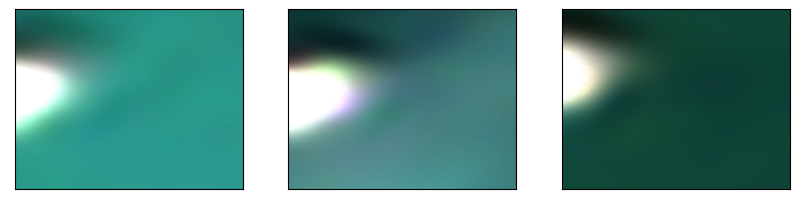

In [28]:
f, axarr = plt.subplots(1, 3, figsize=(10, 6))

axarr[0].imshow(l('2_82.51.png'))
axarr[1].imshow(l('2_85.21.png'))
axarr[2].imshow(l('2_78.02.png'))

for i in range(0, 3):
    axarr[i].set_xticks([]), axarr[i].set_yticks([])

Исследуем это подробнее и поймем, почему является неудачным подход с трехмерным RGB пространством:

In [29]:
def plot_hist(name, pth):
    colors = ('b','g','r')
    f, axarr = plt.subplots(1, 4, figsize=(15, 4))
    f.suptitle(name)
    for i, color in enumerate(colors):
        img = l(pth)
        hist = cv2.calcHist([img],[i], None, [256], [0,256])
        axarr[i].plot(hist, color = color)
        axarr[i].set_title(f'{color.upper()} channel')
        axarr[i].set_yticks([])
        axarr[i].scatter(hist.argmax(), 0, marker='x', s=50, label='Mode')
        axarr[i].scatter(img[:, :, i].mean(), 0, marker='o', s=50, label='Mean')
        axarr[i].scatter(np.median(img[:, :, i]), 0, marker='*', s=50, label='Median')
        axarr[i].legend()
        if i == 2:
            axarr[i + 1].imshow(img)
            axarr[i + 1].set_yticks([])
            axarr[i + 1].set_xticks([])
    plt.show()

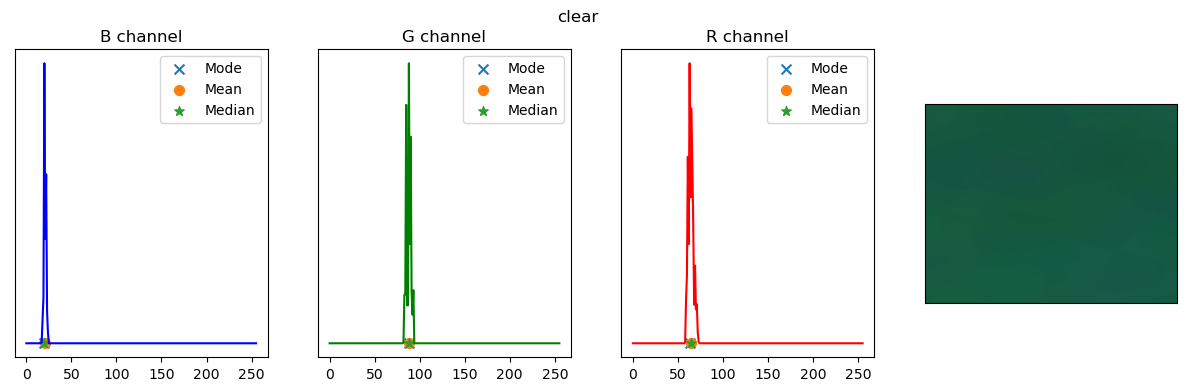

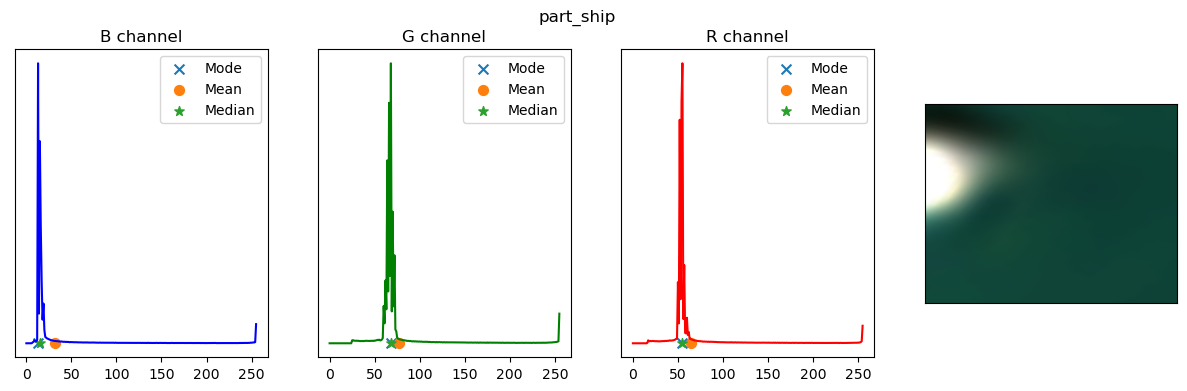

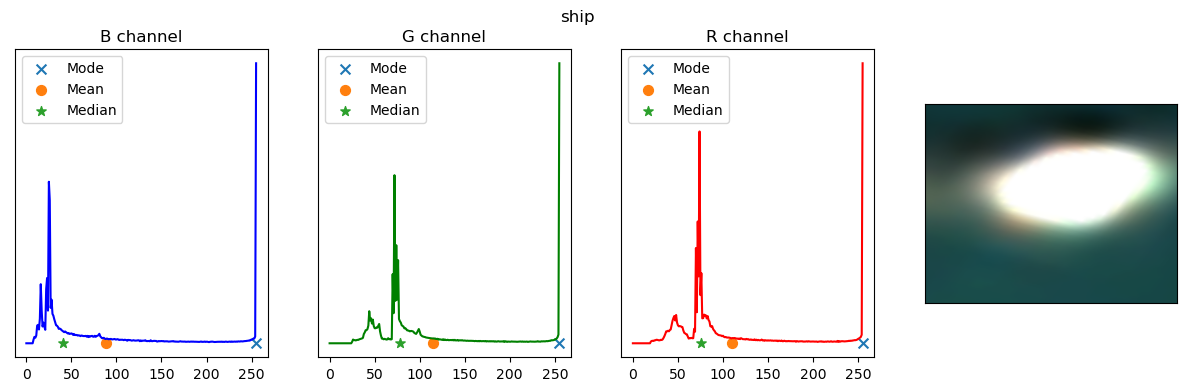

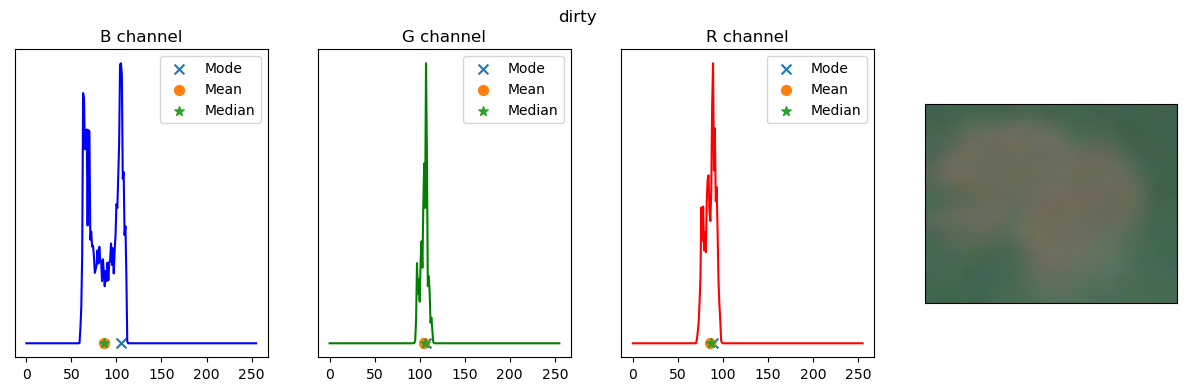

In [30]:
dct = {'clear': '0_79.6617.jpg', 'part_ship': '2_78.02.png', 'ship': '2_68.83.png', 'dirty': '1_54.7977.jpg'}
for key in dct:
    plot_hist(key, dct[key])

Заметим некоторое количество пикслей с околомаксимальными значениями. Именно они являются кораблями (Белый = 255).
Если корабль занимает малую часть изображения, то это почти не влияет на оценки.

Если корабль занимает значительную часть изображения, то он "сносит" неустойчивое средневыборочное, и в трехмерном RGB пространстве корабль и загрязнение разделить сложно. Посмотрим, что будет, если выбрать моду оценкой:

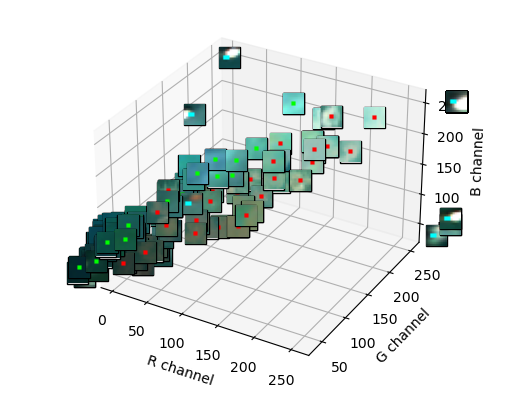

In [31]:
vis = VisExtract('data', len(os.listdir('data')), 'show', ships=True, aver='mode')

Что же, некторые объекты класса "корабль" теперь действительно далеки от загрязнений и "чистых" снимков. 
Однако, часть кораблей все же сливается с другими классами. Это объяснимо конечностью разбиения изображений.

Отметим и факт того, что разные цвета на изображении в среднем могут давать одинаковый результат, что усложняет классиффикацию этим подходом.

Не будем пытаться уменьшать разбиение, вернёмся к ансаблям в пространстве большей размерности.

Итак, попробуем собрать ансамбль из SVC, логистической регрессии, метода К-ближайших соседей, потому что они хорошо себя показали.

Метаалгоритм - метод опорных векторов.

In [32]:
from sklearn.ensemble import StackingClassifier

meta_al = svm.SVC()

base_estimators = [('SVM', finder_svc_pca.best_estimator_), ('LogReg', finder_lr.best_estimator_),
                   ('KNN', finder_knn.best_estimator_), ('RFC', finder_dtc.estimator)]

sclf = StackingClassifier(estimators=base_estimators, final_estimator=meta_al, cv=5)

sclf.fit(trainData_pca, trainLabels)

StackingClassifier(cv=5,
                   estimators=[('SVM',
                                SVC(C=3.6176470588235294, random_state=41)),
                               ('LogReg',
                                LogisticRegression(C=3.6176470588235294,
                                                   max_iter=5000,
                                                   random_state=41)),
                               ('KNN',
                                KNeighborsClassifier(n_neighbors=4,
                                                     weights='distance')),
                               ('RFC', DecisionTreeClassifier())],
                   final_estimator=SVC())

Метрика f1-score:

In [33]:
mac = 'macro'
print(f'F1-мера: {f1_score(testLabels, sclf.predict(testData_pca), average=mac)}')
print(f'Точность: {accuracy_score(testLabels, sclf.predict(testData_pca))}')

F1-мера: 0.9448366013071895
Точность: 0.9468085106382979


Такой же результат получился у лучшего из слабых учеников. Предположу, что ансамбль не улучшил результат по причине того, что данные не совсем корректно размечены, также из-за большого размера "сплита", где 50% снимка, а то и более, могут занимать пиксели, относимые к другому классу.

Также сама гистограмма учитывает лишь непосредственно распределение значений на изображении, но не их взаимное положение.



In [8]:
import keras
import keras_preprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
import albumentations as A

Импорт говорит сам за себя.

In [9]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

Запишем в список изображения. "Утроение" откликов обусловлено дальнейшей аугментацией.

In [10]:
filelist = os.listdir('data')
y = []
imgs = []
for file in filelist:
    imgs.append(read_image('data', file))
    for i in range(0, 3):
        y.append(int(file[0]))

Произведём довольно простую аугментацию, увеличив размер датасета почти до 1000 изображений:

In [11]:
import random
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0725, scale_limit=0.2, rotate_limit=75, p=0.8),
        A.OneOf([
            A.OpticalDistortion(p=0.95),
            A.GridDistortion(p=0.95),
            A.IAAPiecewiseAffine(p=0.95),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.5),
    ])


E:\conda\envs\nns\lib\site-packages\albumentations\imgaug\transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
E:\conda\envs\nns\lib\site-packages\albumentations\imgaug\transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
E:\conda\envs\nns\lib\site-packages\albumentations\imgaug\transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
E:\conda\envs\nns\lib\site-packages\albumentations\imgaug\transforms.py:174: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead",

Аугментация произошла:

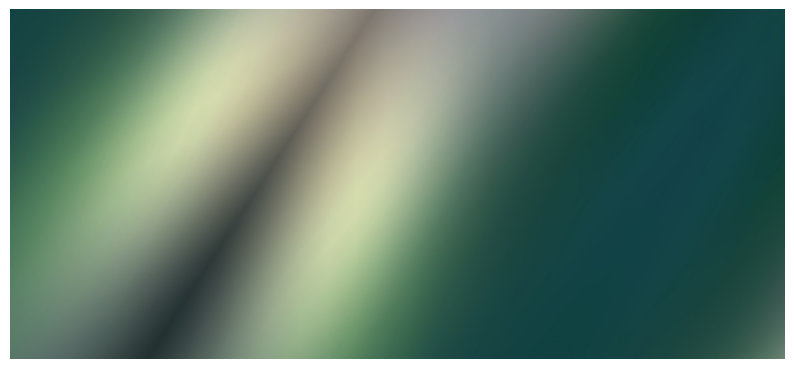

In [17]:
augmented_image = transform(image=imgs[234])['image']
visualize(augmented_image)

In [ ]:
ln = len(imgs)
imgs_augmented = []
for i in range(0, ln):
    for j in range(0, 3):
        img_augmented = transform(image=imgs[i])['image']
        imgs_augmented.append(img_augmented)
imgs_for_vis = imgs_augmented.copy()

In [40]:
for i in range(0, len(imgs_augmented)):
    imgs_augmented[i] = cv2.resize(imgs_augmented[i], (300, 300))

Посмотрим, все ли правильно сработало. Так как мы случайно выбираем изображения для демонстрации, не представляется возможным получить настоящие метки классов. Попробуем их предсказать:

In [41]:
def predict(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = extract_histogram(img)
    img = pca.transform(img.reshape(1, -1))
    return sclf.predict(img)

C:\Users\gradu\AppData\Local\Temp\ipykernel_2024\4130425338.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs_augm = np.random.choice(imgs_for_vis, size=n_cols * n_cols)


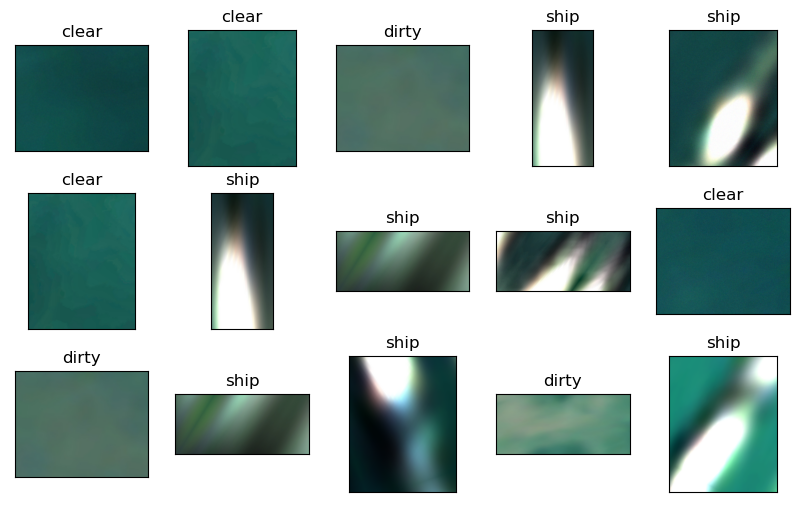

In [42]:
n_rows = 3
n_cols = 5

np.random.seed(13)
imgs_augm = np.random.choice(imgs_for_vis, size=n_cols * n_cols)

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 6))

name = {'0': 'clear', '1': 'dirty', '2': 'ship'}


for i in range(1, n_rows + 1):
    for j in range(1, n_cols + 1):
        axarr[i - 1, j - 1].imshow(imgs_augm[i * j])
        axarr[i - 1, j - 1].set_xticks([]), axarr[i - 1, j - 1].set_yticks([])
        axarr[i - 1, j - 1].set_title(name[predict(imgs_augm[i * j])[0]])

Ансамбль справился с классификацией видоизменённых изображений. Попробуем обучить сверточную нейросеть, но сначала нужно подготовить данные:

In [43]:
data_reshaped = np.concatenate(imgs_augmented, axis=0)

In [44]:
data_reshaped = data_reshaped.reshape(len(os.listdir('data/')) * 3, 300, 300, 3)

In [45]:
data_reshaped[0].shape

(300, 300, 3)

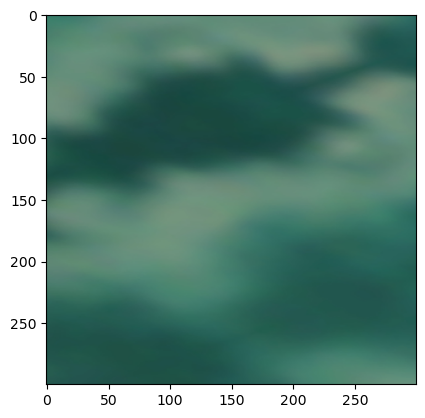

In [46]:
plt.imshow(data_reshaped[567])

In [47]:
data_reshaped = data_reshaped.reshape(len(os.listdir('data/')) * 3, 300, 300, 3)
data_reshaped = data_reshaped.astype('float32')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data_reshaped, y, test_size=0.2, random_state=43)

Нормируем:

In [51]:
X_train = X_train / 255
X_test = X_test / 255

In [52]:
y_train_cat = keras.utils.to_categorical(y_train, 3)
y_test_cat = keras.utils.to_categorical(y_test, 3)

Так как это сеть для классификации, на выходном слое у нас три softmax'a:

In [53]:
cnn_first = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3,  activation='softmax')
])
cnn_first.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 360000)            0         
                                                                 
 dense (Dense)               (None, 128)               4

In [54]:
cnn_first.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
his_first = cnn_first.fit(X_train, y_train_cat, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
19/19 [==============================] - 6s 187ms/step - loss: 8.2779 - accuracy: 0.3557 - val_loss: 0.8908 - val_accuracy: 0.4533
Epoch 2/30
19/19 [==============================] - 2s 124ms/step - loss: 0.7381 - accuracy: 0.6342 - val_loss: 0.4410 - val_accuracy: 0.8600
Epoch 3/30
19/19 [==============================] - 2s 125ms/step - loss: 0.3964 - accuracy: 0.8674 - val_loss: 0.4450 - val_accuracy: 0.7933
Epoch 4/30
19/19 [==============================] - 2s 126ms/step - loss: 0.2980 - accuracy: 0.8977 - val_loss: 0.1917 - val_accuracy: 0.9200
Epoch 5/30
19/19 [==============================] - 2s 125ms/step - loss: 0.2814 - accuracy: 0.9060 - val_loss: 0.1976 - val_accuracy: 0.9000
Epoch 6/30
19/19 [==============================] - 2s 123ms/step - loss: 0.1804 - accuracy: 0.9446 - val_loss: 0.2001 - val_accuracy: 0.9267
Epoch 7/30
19/19 [==============================] - 2s 125ms/step - loss: 0.2468 - accuracy: 0.9312 - val_loss: 0.1536 - val_accuracy: 0.9467
Epoch 

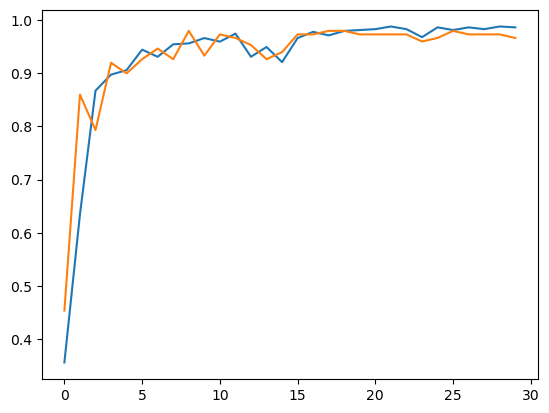

In [55]:
plt.plot(his_first.history['accuracy'], label='accuracy')
plt.plot(his_first.history['val_accuracy'], label='val_accuracy')

In [56]:
im_test = (data_reshaped[567]).astype(np.uint8)

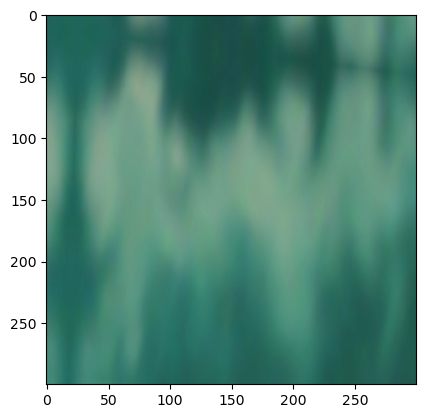

In [135]:
plt.imshow(im_test)

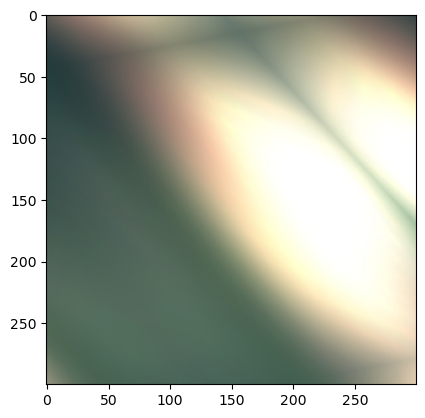

In [165]:
plt.imshow(X_train[89])

In [64]:
x_pca = X_train.reshape(-1, 300*300*3)
x_test_pca = X_test.reshape(-1, 300*300*3)

In [58]:
x_pca.shape

(746, 270000)

In [59]:
test_pca = PCA(n_components=24)
test_pca.fit(x_pca)

PCA(n_components=24)

In [60]:
x_pca = test_pca.transform(x_pca)

In [65]:
x_test_pca = test_pca.transform(x_test_pca)

In [61]:
test_inved = test_pca.inverse_transform(x_pca)

In [62]:
test_inved = test_inved.reshape(746, 300, 300, 3)

In [68]:
x_pca = x_pca.reshape(746, 300, 300, 3)

In [69]:
his_first = cnn_first.fit(x_pca, y_train_cat, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
19/19 [==============================] - 3s 142ms/step - loss: 0.0301 - accuracy: 0.9916 - val_loss: 0.2857 - val_accuracy: 0.9533
Epoch 2/30
19/19 [==============================] - 2s 124ms/step - loss: 0.1468 - accuracy: 0.9547 - val_loss: 0.2666 - val_accuracy: 0.9533
Epoch 3/30
19/19 [==============================] - 2s 126ms/step - loss: 0.0745 - accuracy: 0.9765 - val_loss: 0.3233 - val_accuracy: 0.9467
Epoch 4/30
19/19 [==============================] - 2s 127ms/step - loss: 0.0446 - accuracy: 0.9849 - val_loss: 0.2593 - val_accuracy: 0.9733
Epoch 5/30
19/19 [==============================] - 2s 125ms/step - loss: 0.0349 - accuracy: 0.9916 - val_loss: 0.2307 - val_accuracy: 0.9733
Epoch 6/30
19/19 [==============================] - 2s 123ms/step - loss: 0.0341 - accuracy: 0.9866 - val_loss: 0.2488 - val_accuracy: 0.9733
Epoch 7/30
19/19 [==============================] - 2s 123ms/step - loss: 0.0379 - accuracy: 0.9933 - val_loss: 0.2336 - val_accuracy: 0.9800
Epoch 

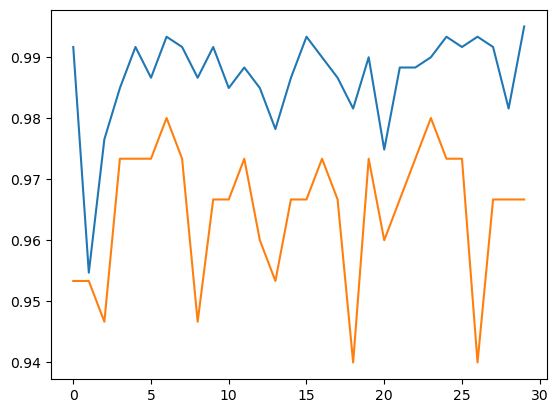

In [70]:
plt.plot(his_first.history['accuracy'], label='accuracy')
plt.plot(his_first.history['val_accuracy'], label='val_accuracy')

Добавим регуляризацию:

In [61]:
cnn_first_reg = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
    keras.layers.Dense(3,  activation='softmax')
])

In [62]:
cnn_first_reg.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
 
his_reg = cnn_first_reg.fit(X_train, y_train_cat, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
19/19 [==============================] - 3s 143ms/step - loss: 6.7811 - accuracy: 0.5990 - val_loss: 3.0428 - val_accuracy: 0.6867
Epoch 2/30
19/19 [==============================] - 2s 127ms/step - loss: 2.3241 - accuracy: 0.8339 - val_loss: 1.4503 - val_accuracy: 0.9467
Epoch 3/30
19/19 [==============================] - 2s 128ms/step - loss: 1.1636 - accuracy: 0.9195 - val_loss: 0.7585 - val_accuracy: 0.9667
Epoch 4/30
19/19 [==============================] - 2s 130ms/step - loss: 0.7166 - accuracy: 0.9161 - val_loss: 0.5098 - val_accuracy: 0.9733
Epoch 5/30
19/19 [==============================] - 2s 128ms/step - loss: 0.5270 - accuracy: 0.9262 - val_loss: 0.4522 - val_accuracy: 0.9067
Epoch 6/30
19/19 [==============================] - 2s 127ms/step - loss: 0.4422 - accuracy: 0.9295 - val_loss: 0.2806 - val_accuracy: 0.9867
Epoch 7/30
19/19 [==============================] - 2s 127ms/step - loss: 0.3603 - accuracy: 0.9379 - val_loss: 0.2813 - val_accuracy: 0.9467
Epoch 

In [63]:
cnn_third = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
cnn_third.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 19, 19, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 9, 128)       

In [64]:
cnn_third.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
 
his_third = cnn_third.fit(X_train, y_train_cat, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
19/19 [==============================] - 3s 120ms/step - loss: 0.9801 - accuracy: 0.5000 - val_loss: 0.8549 - val_accuracy: 0.6867
Epoch 2/30
19/19 [==============================] - 2s 83ms/step - loss: 0.6274 - accuracy: 0.7836 - val_loss: 0.2092 - val_accuracy: 0.9333
Epoch 3/30
19/19 [==============================] - 2s 83ms/step - loss: 0.2857 - accuracy: 0.8977 - val_loss: 0.1302 - val_accuracy: 0.9733
Epoch 4/30
19/19 [==============================] - 2s 82ms/step - loss: 0.2058 - accuracy: 0.9312 - val_loss: 0.1013 - val_accuracy: 0.9733
Epoch 5/30
19/19 [==============================] - 2s 82ms/step - loss: 0.2318 - accuracy: 0.9111 - val_loss: 0.1496 - val_accuracy: 0.9533
Epoch 6/30
19/19 [==============================] - 2s 82ms/step - loss: 0.2713 - accuracy: 0.9027 - val_loss: 0.2876 - val_accuracy: 0.8933
Epoch 7/30
19/19 [==============================] - 2s 82ms/step - loss: 0.1727 - accuracy: 0.9497 - val_loss: 0.1011 - val_accuracy: 0.9667
Epoch 8/30
1

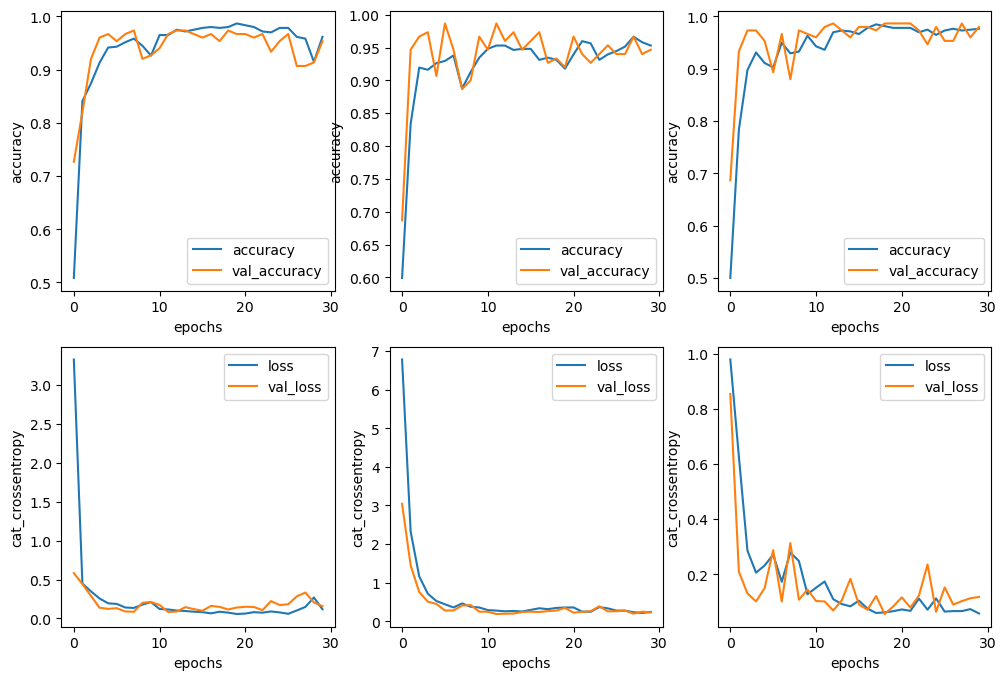

In [67]:
histories = [his_first, his_reg, his_third]

n_rows = 2
n_clms = 3

f, axarr = plt.subplots(n_rows, n_clms, figsize=(12, 8))

for i, his in enumerate(histories):
    
    axarr[0][i].plot(his.history['accuracy'], label='accuracy')
    axarr[0][i].plot(his.history['val_accuracy'], label='val_accuracy')
    axarr[0][i].set_xlabel('epochs')
    axarr[0][i].set_ylabel('accuracy')
    axarr[0][i].legend()
    
    axarr[1][i].plot(his.history['loss'], label='loss')
    axarr[1][i].plot(his.history['val_loss'], label='val_loss')
    axarr[1][i].set_xlabel('epochs')
    axarr[1][i].set_ylabel('cat_crossentropy')
    axarr[1][i].legend()
    

In [68]:
solvers = [cnn_first, cnn_first_reg, cnn_third]

for solv in solvers:
    y = solv.predict(X_test)
    y = np.argmax(y, axis=-1)
    cnf_mtx = pd.DataFrame(confusion_matrix(y_test, y), columns=['clear', 'dirty', 'ship'], index=['clear', 'dirty', 'ship'])
    cnf_mtx.columns.name = 'act \ pred'
    mc = 'micro'
    print(f'confusion matrix for: {solv._name}, f1_scores = {f1_score(y_test, y, average=mc)}')
    print(cnf_mtx)
    print()

6/6 [==============================] - 1s 109ms/step
confusion matrix for: sequential, f1_scores = 0.9144385026737968
act \ pred  clear  dirty  ship
clear          58      2     0
dirty           2     71     0
ship            1     11    42

6/6 [==============================] - 0s 34ms/step
confusion matrix for: sequential_1, f1_scores = 0.946524064171123
act \ pred  clear  dirty  ship
clear          59      1     0
dirty           1     68     4
ship            0      4    50

6/6 [==============================] - 0s 63ms/step
confusion matrix for: sequential_2, f1_scores = 0.9786096256684492
act \ pred  clear  dirty  ship
clear          59      1     0
dirty           1     70     2
ship            0      0    54



Что же, почти одинаковые результаты у трёх моделей, которые не сильно отличаются от результата Stacking ансамбля.

**Вывод:** поставленная задача может быть решена методом разбиения области интереса на части и их классификации. Лучшим из методов классического МО оказался метод SVM, что неудивительно, ведь именно он долгое время был State of the art в сфере CV.

Свёрточные сети для классификации показали себя немного сильнее, результат их можно улучшить, однако для решения данной задачи отпимальный вариант - CNN для детектирования или сегментации сущностей, ведь тогда не будет стоять вопроса о размере разбиения изображения, машина сделает все сама, в этом и смысл глубокого обучения.